In [1]:
from pylab import *
from scipy import integrate
from scipy.optimize import minimize 
from scipy import interpolate

# Analysis of ANAIS-112

### Given parameters (from arXiv:2103.01175v2)
$M = 12.5$ kg per detector, $\Delta t = 10$ days, $\omega = 0.01721$ rad / days, $t_0 = -62.2$ days, 
$\Delta E$ is energy interval width and $\phi_{bkg}(t_i)=1+fe^{-t_i/\tau}$

## Extraction of efficiency curves data

In [16]:
# 50 energy points and 9 detectors
# 2 keV start at position 10

# Read data file
effdata1_6 = []
for i in range(9):
    effdata1_6.append( np.loadtxt('Data/ANAIS112eff_3y_D{}.csv'.format(i), delimiter=',') )

### Sort data for efficiency, energy and error

In [17]:
# Sort data for 1-6 keV
energy1_6 = np.zeros( (9, len(effdata1_6[0][:,0]) ) )
efficiency1_6 = np.zeros( (9, len(effdata1_6[0][:,0]) ) )
erroreff1_6 = np.zeros( (9, len(effdata1_6[0][:,0]) ) )

# Separate data for each detector in 1-6 keV
for i in range(9):
    energy1_6[i] = effdata1_6[i][:,0]
    efficiency1_6[i] = effdata1_6[i][:,1]
    erroreff1_6[i] = effdata1_6[i][:,2]

In [18]:
# Sort data for 1-2 keV
energy1_2 = np.zeros( (9, len(effdata1_6[0][:,0][0:10]) ) )
efficiency1_2 = np.zeros( (9, len(effdata1_6[0][:,0][0:10]) ) )
erroreff1_2 = np.zeros( (9, len(effdata1_6[0][:,0][0:10]) ) )

# Separate data for each detector in 2-6 keV
for i in range(9):
    energy1_2[i] = energy1_6[i][0:10]
    efficiency1_2[i] = efficiency1_6[i][0:10]
    erroreff1_2[i] = erroreff1_6[i][0:10]

In [19]:
# Sort data for 2-6 keV
energy2_6 = np.zeros( (9, len(effdata1_6[0][:,0][10::]) ) )
efficiency2_6 = np.zeros( (9, len(effdata1_6[0][:,0][10::]) ) )
erroreff2_6 = np.zeros( (9, len(effdata1_6[0][:,0][10::]) ) )

# Separate data for each detector in 2-6 keV
for i in range(9):
    energy2_6[i] = energy1_6[i][10::]
    efficiency2_6[i] = efficiency1_6[i][10::]
    erroreff2_6[i] = erroreff1_6[i][10::]

### Computation of efficiency weight from total area and area below curve

In [20]:
# Area of square 1*deltaE
Range = 6
Maximum_eff = 1
area_range = Range*Maximum_eff #keV

# Area below efficiency curve
area_curve = zeros(9)
for i in range(9):
    area_curve[i] = integrate.simpson(efficiency1_6[i], energy1_6[i])

# Efficiency weight
epsilon = area_curve/area_range

## Extraction of counts data

In [21]:
# 110 count points and 9 detectors

# Read data file (1-6 keV)
data1_6 = []
for i in range(9):
    data1_6.append( np.loadtxt('Data/ANAIS112_3y_10days_1keV_6keV_D{}.csv'.format(i), delimiter=',') )

# Sort data for 1-6 keV
day1_6 = np.zeros( (9, len(data1_6[0][:,0]) ) )
count1_6 = np.zeros( (9, len(data1_6[0][:,0]) ) )
errorcount1_6 = np.zeros( (9, len(data1_6[0][:,0]) ) )

# Separate data for each detector in 1-6 keV
for i in range(9):
    day1_6[i] = data1_6[i][:,0]
    count1_6[i] = data1_6[i][:,1]
    errorcount1_6[i] = data1_6[i][:,2]

In [22]:
# Read data file (2-6 keV)
data2_6 = []
for i in range(9):
    data2_6.append( np.loadtxt('Data/ANAIS112_3y_10days_2keV_6keV_D{}.csv'.format(i), delimiter=',') )

# Sort data for 2-6 keV
day2_6 = np.zeros( (9, len(data1_6[0][:,0]) ) )
count2_6 = np.zeros( (9, len(data1_6[0][:,0]) ) )
errorcount2_6 = np.zeros( (9, len(data1_6[0][:,0]) ) )

# Separate data for each detector in 2-6 keV
for i in range(9):
    day2_6[i] = data2_6[i][:,0]
    count2_6[i] = data2_6[i][:,1]
    errorcount2_6[i] = data2_6[i][:,2]

## Extraction of live-time values for each bin

In [23]:
# Live-time values (110) for each count point
# Energy interval width from energy data of efficiency
livetime = np.loadtxt('Data/ANAIS112liveTime_3y_10days.csv') / 10
index = where(livetime < 0.85)

## Reweigh count data by efficiency and live-time

In [27]:
# Detector values reported
deltaE = 5
M = 12.5 

# Select energy range 1-2 keV for counts
day1_2 = np.zeros((9,len(data1_6[0][:,0])))
count1_2 = np.zeros((9,len(data1_6[0][:,0])))
errorcount1_2 = np.zeros((9,len(data1_6[0][:,0])))

# Reweighting data
for i in range(9):
    day1_2[i] = data1_6[i][:,0]
    count1_2[i] = np.round( (data1_6[i][:,1] - data2_6[i][:,1]) / (livetime * epsilon[i]) )
    count1_6[i] =  np.round( data1_6[i][:,1] * M * deltaE / (livetime * epsilon[i]) )
    errorcount1_2[i] = data1_6[i][:,2] + data2_6[i][:,2]

In [28]:
# Keep data with livetime below 0.85
livetimes = np.delete(livetime, index)
counts1_6 = zeros( (9, len(livetimes) ) )
for i in range(0,9):
    counts1_6[i] = np.delete(count1_6[i], index)
days1_6 = zeros( (9,len(livetimes) ) )
for i in range(0,9):
    days1_6[i] = np.delete(day1_6[i], index)

## Computation of expectation value

### Expectation value $\mu_i = [R_0\phi_{bkg}(t_i)+S_m\cos{(\omega(t_i - t_0))}]M \Delta E \Delta t$

In [32]:
# Fixed parameters
omega = 0.01721
deltaE = 5
M = 12.5
deltat = 10

# Expectation value as function of free parameters
def Exp_value(R0,Sm,tau,f,t0,detector):
    ti = days1_6[detector]
    phi = 1 + f * exp(-ti / tau)
    mu = ( (R0 * phi) + (Sm * cos( omega * (ti - t0) )) ) * M * deltaE * deltat
    mu_weighted = mu * (livetimes * epsilon[detector])
    return mu_weighted

## Computation of likelihood

### $L=\prod_{det}\prod_{i}\frac{e^{\mu_i}\mu_i^{n_i}}{n_i!}$ with $n_i$ number of events in bin $i$

In [39]:
# Likelihood with t0 fixed for all detectors (in log-form)
def Likelihood_total(parameters):
    t0 = -62.2
    Sm, R0_1, tau_1, f_1, R0_2, tau_2, f_2, R0_3, tau_3, f_3, R0_4, tau_4, f_4, R0_5, tau_5, f_5, R0_6, tau_6, f_6, R0_7, tau_7, f_7, R0_8, tau_8, f_8, R0_9, tau_9, f_9 = parameters
    R0 = array( (R0_1, R0_2, R0_3, R0_4, R0_5, R0_6, R0_7, R0_8, R0_9) )
    tau = array( (tau_1, tau_2, tau_3, tau_4, tau_5, tau_6, tau_7, tau_8, tau_9) )
    f = array( (f_1, f_2, f_3, f_4, f_5, f_6, f_7, f_8, f_9) )
    L = zeros(9)
    for i in range(0,9):
        detector = i
        mu = Exp_value(R0[i], Sm, tau[i], f[i], t0, detector)
        L_d = -mu + ( counts1_6[detector] * log(mu) )  - (counts1_6[detector] * log(counts1_6[detector]) - counts1_6[detector] )
        L[i] = sum(L_d)
    return -2*sum(L)

In [40]:
# Initial guesses for free parameters
R0_initial = 3.6
Sm_initial = -0.0045
tau_initial = 1034
f_initial = 0.2

### Maximization of likelihood

In [36]:
# Minimization of -2ln(L) (equivalent)
minimize(Likelihood_total, (Sm_initial, R0_initial, tau_initial, f_initial, R0_initial, tau_initial, f_initial, R0_initial, tau_initial, f_initial, R0_initial, tau_initial, f_initial, R0_initial, tau_initial, f_initial, R0_initial, tau_initial, f_initial, R0_initial, tau_initial, f_initial, R0_initial, tau_initial, f_initial, R0_initial, tau_initial, f_initial), method='L-BFGS-B')

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 2869.2635036668
        x: [-5.513e-03  4.736e+00 ...  1.034e+03  5.107e-01]
      nit: 44
      jac: [ 2.879e-01  6.585e-02 ...  2.729e-02  1.883e-01]
     nfev: 1421
     njev: 49
 hess_inv: <28x28 LbfgsInvHessProduct with dtype=float64>

## Find confidence interval for best fit

### Method chosen by statistic $\Delta\chi^2_i = -2 \ln\left(\frac{L_{max, i}}{L_{max, 0}}\right)$ with $L_{max, 0}$ the likelihood for best fit, such that $\Delta\chi^2=1$ gives confidence interval

In [41]:
# Compute the likelihood value for best fit
output = minimize(Likelihood_total, (Sm_initial, R0_initial, tau_initial, f_initial, R0_initial, tau_initial, f_initial, R0_initial, tau_initial, f_initial, R0_initial, tau_initial, f_initial, R0_initial, tau_initial, f_initial, R0_initial, tau_initial, f_initial, R0_initial, tau_initial, f_initial, R0_initial, tau_initial, f_initial, R0_initial, tau_initial, f_initial), method='L-BFGS-B')
best_fit_values = output['x']
logL_max = Likelihood_total(best_fit_values)

# Create range of Sm values to scan
Sm_fit = best_fit_values[0]
S = zeros(50)
for i in range(0,25):
    S[i] = Sm_fit - i/1000
for i in range(25,50):
    S[i] = Sm_fit + (i-24)/1000
S = sort(S)

In [42]:
# Scan likelihood over S range (fixing it at each point) and compute chi^2
chi_sqrd = zeros(50)
for k in range(0,50):
    Sm = S[k]
    def Likelihood_uncertainty(parameters):
        t0 = -62.2
        R0_1, tau_1, f_1, R0_2, tau_2, f_2, R0_3, tau_3, f_3, R0_4, tau_4, f_4, R0_5, tau_5, f_5, R0_6, tau_6, f_6, R0_7, tau_7, f_7, R0_8, tau_8, f_8, R0_9, tau_9, f_9 = parameters
        R0 = array( (R0_1, R0_2, R0_3, R0_4, R0_5, R0_6, R0_7, R0_8, R0_9) )
        tau = array( (tau_1, tau_2, tau_3, tau_4, tau_5, tau_6, tau_7, tau_8, tau_9) )
        f = array( (f_1, f_2, f_3, f_4, f_5, f_6, f_7, f_8, f_9) )
        L = zeros(9)
        for i in range(0,9):
            detector = i
            mu = Exp_value(R0[i], Sm, tau[i], f[i], t0, detector)
            L_d = -mu + ( counts1_6[detector] * log(mu) ) - (counts1_6[detector] * log(counts1_6[detector]) - counts1_6[detector] )
            L[i] = sum(L_d)
        return (-2)*sum(L)
    output_uncertainty = minimize(Likelihood_uncertainty, (R0_initial, tau_initial, f_initial, R0_initial, tau_initial, f_initial, R0_initial, tau_initial, f_initial, R0_initial, tau_initial, f_initial, R0_initial, tau_initial, f_initial, R0_initial, tau_initial, f_initial, R0_initial, tau_initial, f_initial, R0_initial, tau_initial, f_initial, R0_initial, tau_initial, f_initial), method='L-BFGS-B')
    best_fit_values_uncertainty = output_uncertainty['x']
    logL = Likelihood_uncertainty(best_fit_values_uncertainty)
    chi_sqrd[k] = logL - logL_max

In [43]:
# Find Sm value for which chi^2 is equal to one
yToFind = 1
yreduced = np.array(chi_sqrd) - yToFind
freduced = interpolate.UnivariateSpline(S, yreduced, s=0)
Sm_interval = freduced.roots()

# Extracting best fit value and uncertainties
print('Best fit for Sm:', Sm_fit)
print('Lower interval:', Sm_fit - Sm_interval[0])
print('Upper interval:', Sm_interval[1] - Sm_fit)

Best fit for Sm: -0.005513221385514619
Lower interval: 0.004395651288815678
Upper interval: 0.004388893504889748


### Best fit for amplitude is -0.0055 $\pm$ 0.0043 cpd/kg/keV

## Repetition of likelihood maximization with $t_0$ released

In [45]:
# Likelihood with t0 released for all detectors
def Likelihood_totalv2(parameters):
    Sm, t0, R0_1, tau_1, f_1, R0_2, tau_2, f_2, R0_3, tau_3, f_3, R0_4, tau_4, f_4, R0_5, tau_5, f_5, R0_6, tau_6, f_6, R0_7, tau_7, f_7, R0_8, tau_8, f_8, R0_9, tau_9, f_9 = parameters
    R0 = array( (R0_1, R0_2, R0_3, R0_4, R0_5, R0_6, R0_7, R0_8, R0_9) )
    tau = array( (tau_1, tau_2, tau_3, tau_4, tau_5, tau_6, tau_7, tau_8, tau_9) )
    f = array( (f_1, f_2, f_3, f_4, f_5, f_6, f_7, f_8, f_9) )
    L = zeros(9)
    for i in range(0,9):
        detector = i
        mu = Exp_value(R0[i], Sm, tau[i], f[i], t0, detector)
        L_d = -mu + ( counts1_6[detector] * log(mu) ) - (counts1_6[detector] * log(counts1_6[detector]) - counts1_6[detector] )
        L[i] = sum(L_d)
    return (-2)*sum(L)

In [46]:
# Initial guesses for free parameters
R0_initial = 3.6
Sm_initial = -0.0045
tau_initial = 1034
f_initial = 0.2
t0_initial = -62.2

In [47]:
# Minimization of -2ln(L)
minimize(Likelihood_totalv2, (Sm_initial, t0_initial, R0_initial, tau_initial, f_initial, R0_initial, tau_initial, f_initial, R0_initial, tau_initial, f_initial, R0_initial, tau_initial, f_initial, R0_initial, tau_initial, f_initial, R0_initial, tau_initial, f_initial, R0_initial, tau_initial, f_initial, R0_initial, tau_initial, f_initial, R0_initial, tau_initial, f_initial), method='L-BFGS-B')

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 2869.2635570769307
        x: [-5.514e-03 -6.220e+01 ...  1.034e+03  5.107e-01]
      nit: 44
      jac: [ 2.277e-01 -9.350e-02 ...  2.838e-02  1.713e-01]
     nfev: 1470
     njev: 49
 hess_inv: <29x29 LbfgsInvHessProduct with dtype=float64>

## Repetition of confidence intervals with $t_0$  released

In [48]:
# Compute the likelihood value for best fit
output = minimize(Likelihood_totalv2, (Sm_initial, t0_initial, R0_initial, tau_initial, f_initial, R0_initial, tau_initial, f_initial, R0_initial, tau_initial, f_initial, R0_initial, tau_initial, f_initial, R0_initial, tau_initial, f_initial, R0_initial, tau_initial, f_initial, R0_initial, tau_initial, f_initial, R0_initial, tau_initial, f_initial, R0_initial, tau_initial, f_initial), method='L-BFGS-B')
best_fit_values = output['x']
logL_max = Likelihood_totalv2(best_fit_values)

# Create range of Sm values to scan
Sm_fit = best_fit_values[0]
S = zeros(11)
for i in range(0,6):
    S[i] = Sm_fit - i/1000
for i in range(6,11):
    S[i] = Sm_fit + (i-5)/1000
S = sort(S)

# Create range of t0 values to scan
t0_fit = best_fit_values[1]
t_0 = zeros(11)
for i in range(0,6):
    t_0[i] = t0_fit - i * 5
for i in range(6,11):
    t_0[i] = t0_fit + (i-5) * 5
t_0 = sort(t_0)

In [49]:
# Scan likelihood over S and t0 ranges (fixing them at each point) and compute chi^2
chi_sqrd = zeros((11,11))
for k in range(0,11):
    for j in range(0,11):
        Sm = S[k]
        t0 = t_0[j]
        def Likelihood_uncertaintyv2(parameters):
            R0_1, tau_1, f_1, R0_2, tau_2, f_2, R0_3, tau_3, f_3, R0_4, tau_4, f_4, R0_5, tau_5, f_5, R0_6, tau_6, f_6, R0_7, tau_7, f_7, R0_8, tau_8, f_8, R0_9, tau_9, f_9 = parameters
            R0 = array( (R0_1, R0_2, R0_3, R0_4, R0_5, R0_6, R0_7, R0_8, R0_9) )
            tau = array( (tau_1, tau_2, tau_3, tau_4, tau_5, tau_6, tau_7, tau_8, tau_9) )
            f = array( (f_1, f_2, f_3, f_4, f_5, f_6, f_7, f_8, f_9) )
            L = zeros(9)
            for i in range(0,9):
                detector = i
                mu = Exp_value(R0[i], Sm, tau[i], f[i], t0, detector)
                L_d = -mu + ( counts1_6[detector] * log(mu) ) - (counts1_6[detector] * log(counts1_6[detector]) - counts1_6[detector] )
                L[i] = sum(L_d)
            return (-2)*sum(L)
        output_uncertainty = minimize(Likelihood_uncertaintyv2, (R0_initial, tau_initial, f_initial, R0_initial, tau_initial, f_initial, R0_initial, tau_initial, f_initial, R0_initial, tau_initial, f_initial, R0_initial, tau_initial, f_initial, R0_initial, tau_initial, f_initial, R0_initial, tau_initial, f_initial, R0_initial, tau_initial, f_initial, R0_initial, tau_initial, f_initial), method='L-BFGS-B')
        best_fit_values_uncertainty = output_uncertainty['x']
        logL = Likelihood_uncertaintyv2(best_fit_values_uncertainty)
        chi_sqrd[k,j] = logL - logL_max

In [53]:
# Separate array in two planes for each variable
Sm_plane = chi_sqrd[:,5]
t0_plane = chi_sqrd[5,:] 

# Find Sm value for which chi^2 is equal to one
yToFind = 1
yreduced = np.array(Sm_plane) - yToFind
freduced = interpolate.UnivariateSpline(S, yreduced, s=0)
Sm_interval = freduced.roots()

# Find t0 value for which chi^2 is equal to one
yToFind = 1
yreduced = np.array(t0_plane) - yToFind
freduced = interpolate.UnivariateSpline(t_0, yreduced, s=0)
t0_interval = freduced.roots()

In [56]:
# Extracting best fit value and uncertainties
print('Best fit for Sm:', Sm_fit)
print('Lower interval:', Sm_fit - Sm_interval[0])
print('Upper interval:', Sm_interval[1] - Sm_fit)
print('Best fit for $t_0$:', t0_fit)
print('Lower interval:', t0_fit - t0_interval[0])
#print('Upper interval:', t0_interval[1] - t0_fit) #Out of bounds

Best fit for Sm: -0.005514115874251274
Lower interval: 0.004394698395396447
Upper interval: 0.004389873267259304
Best fit for $t_0$: -62.20051414797706
Lower interval: 9.908463510471051


### Best fit for amplitude is -0.00551 $\pm$ 0.00439
### Best fit for $t_0$ is -62.2 (- 9.9)

## Comparison plot of signal amplitudes with ANAIS-112 AND DAMA/LIBRA

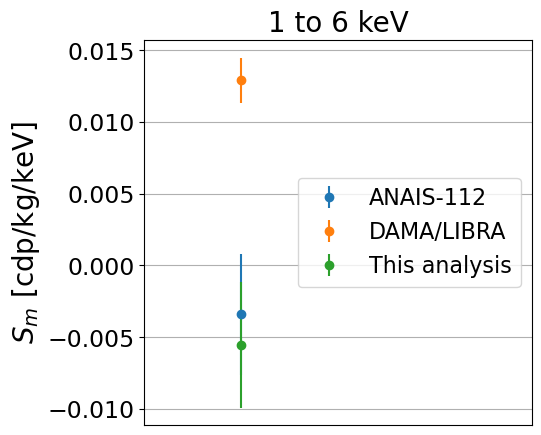

In [60]:
# Reported singal amplitudes by both experiments
ANAIS = -0.0034
ANAIS_error = 0.0042
DAMA = 0.0129
DAMA_error = 0.0016
Us = -0.00551
Us_error= 0.00439

figure(figsize=(5, 5))
errorbar(0, ANAIS, yerr=ANAIS_error, fmt='o', label='ANAIS-112')
errorbar(0, DAMA, yerr=DAMA_error, fmt='o', label='DAMA/LIBRA')
errorbar(0, Us, yerr=Us_error, fmt='o', label='This analysis')
title('1 to 6 keV',fontsize=20)
ylabel(r'$S_m$ [cdp/kg/keV]',fontsize=20)
legend(fontsize=16, loc='center right')
grid(axis='y')
xlim(-1,3)
yticks(fontsize=17)
xticks(fontsize=17)
tick_params(bottom=False,labelbottom=False)
savefig('Modulation amplitude.pdf')